In [1]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
pilot_file = "Batch_3198536_batch_results.csv"

In [2]:
data = pd.read_csv(pilot_file)
data.columns = [c.replace('.', '_') for c in data.columns]
#data.head()

In [3]:
def extract_dataframe(data):
    '''
    Input: Pandas csv dataframe obtained from MTurk
    
    Output: Pandas dataframe levelled by (User x Sentenced_ID)
    '''
    data["dicts"] = data["Input_var_arrays"].map(lambda x: json.loads(x))
    global_list = []
    
    for row in data.itertuples():
        for idx, local_dict in enumerate(row.dicts):
            temp_dict = local_dict.copy()
            var_instant = "Answer_instantaneous" + str(idx+1)
            var_instant_c =  "Answer_confidence_instantaneous" + str(idx+1)
            var_start = "Answer_startpt" + str(idx+1)
            var_start_c = "Answer_confidence_startpoint" + str(idx+1)
            var_end = "Answer_endpt" + str(idx+1)
            var_end_c = "Answer_confidence_endpoint" + str(idx+1)
            var_duration = "Answer_duration" + str(idx+1)
            var_duration_c = "Answer_confidence_duration" + str(idx+1)

            temp_dict["is_instant"] = getattr(row, var_instant)
            temp_dict["instant_conf"] = getattr(row, var_instant_c)
            temp_dict["has_start"] = getattr(row, var_start)
            temp_dict["has_start_conf"] = getattr(row, var_start_c)
            temp_dict["has_end"] = getattr(row, var_end)
            temp_dict["has_end_conf"] = getattr(row, var_end_c)
            temp_dict["duration"] = getattr(row, var_duration)
            temp_dict["duration_conf"] = getattr(row, var_duration_c)
            temp_dict["worker_id"] = row.WorkerId

            global_list.append(temp_dict)
            
    return pd.DataFrame(global_list)


In [4]:
pilot_data = extract_dataframe(data)

#Re-arrange the order 
cols = list(pilot_data.columns)
pilot_data = pilot_data[pilot_data.columns[::-1]].drop('sentence', axis=1)
pilot_data.replace('na',np.NaN, inplace=True)
pilot_data.head()

,worker_id,sentence_id,pred_token,pred,is_instant,instant_conf,id,has_start_conf,has_start,has_end_conf,has_end,duration_conf,duration
0,AQ2U4H38MELRY,en-ud-train.conllu 5784,3,occurred,True,2,1,NaN,NaN,NaN,NaN,NaN,NaN
1,AQ2U4H38MELRY,en-ud-train.conllu 5784,5,processing,False,2,2,3,true,2,false,2,7
2,AQ2U4H38MELRY,en-ud-train.conllu 1010,3,held,False,3,3,1,false,2,false,0,5
3,AQ2U4H38MELRY,en-ud-train.conllu 1010,15,curating,False,4,4,2,false,2,false,1,5
4,AQ2U4H38MELRY,en-ud-train.conllu 5106,20,acted,False,2,5,3,false,3,false,0,5


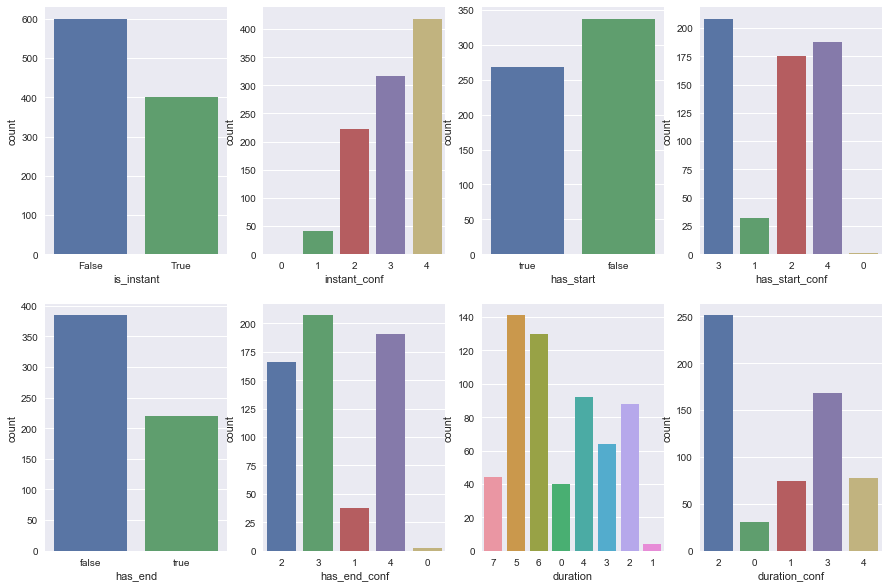

In [5]:
#fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2)

fig, axs = plt.subplots(ncols=4, nrows=2, figsize=(15, 10))

sns.countplot(x='is_instant', data=pilot_data, ax=axs[0][0])
sns.countplot(x='instant_conf', data=pilot_data, ax=axs[0][1])
sns.countplot(x='has_start', data=pilot_data, ax=axs[0][2])
sns.countplot(x='has_start_conf', data=pilot_data, ax=axs[0][3])
sns.countplot(x='has_end', data=pilot_data, ax=axs[1][0])
sns.countplot(x='has_end_conf', data=pilot_data, ax=axs[1][1])
sns.countplot(x='duration', data=pilot_data, ax=axs[1][2])
sns.countplot(x='duration_conf', data=pilot_data, ax=axs[1][3])


plt.show()